<a href="https://colab.research.google.com/github/vedantdalvi7/Robustness-Evaluation-of-Neural-Network-based-image-processing-models/blob/main/cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from __future__ import print_function, absolute_import, division
from collections import namedtuple
from keras.metrics import MeanIoU

In [3]:
print("tensorflow version: {}".format(tf.__version__))

tensorflow version: 2.12.0


In [4]:
!pip show keras

Name: keras
Version: 2.12.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: keras-vis, tensorflow


# Load Datasets

In [5]:
os.listdir('/content/gdrive/MyDrive/dataset')

['images_prepped_train',
 'annotations_prepped_train_greyscale',
 'corrupted_test_images']

In [6]:
#Train samples
img_path = "/content/gdrive/MyDrive/dataset/images_prepped_train/"
annot_path = "/content/gdrive/MyDrive/dataset/annotations_prepped_train_greyscale/"

#Corrupted samples
test_gaussian_path = "/content/gdrive/MyDrive/dataset/corrupted_test_images/gaussian noise 5/"
test_impulse_path = "/content/gdrive/MyDrive/dataset/corrupted_test_images/impulse noise 5/"
#test_shot_path = "/content/gdrive/MyDrive/dataset/corrupted_test_images/shot noise 5/"

#Sort images
list_img = np.sort(next(os.walk(img_path), (None, None, []))[2])
list_annot = np.sort(next(os.walk(annot_path), (None, None, []))[2])

list_test_gaussian = np.sort(next(os.walk(test_gaussian_path), (None, None, []))[2])
list_test_impulse = np.sort(next(os.walk(test_impulse_path), (None, None, []))[2])
#list_test_shot = np.sort(next(os.walk(test_shot_path), (None, None, []))[2])
len(list_img), len(list_annot)

(365, 365)

In [7]:
len(list_test_gaussian)


365

In [8]:
len(list_test_impulse)

365

In [9]:
#len(list_test_shot)

In [10]:
# to make sure our annotation dataset has same name with our image
list_img[300], list_annot[300]

('strasbourg_000001_047619_leftImg8bit.png',
 'strasbourg_000001_047619_gtFine_labelIds.png')

In [11]:
import glob

train_images_dir = sorted(glob.glob(img_path+'/*.png'))
train_annotations_dir = sorted(glob.glob(annot_path+'/*.png'))

test_images_gaussian_dir = sorted(glob.glob(test_gaussian_path+'/*.png'))
test_images_impulse_dir = sorted(glob.glob(test_impulse_path+'/*.png'))
#test_images_shot_dir = sorted(glob.glob(test_shot_path+'/*.png'))


In [12]:
# convert to list of images
train_images = []
for img in train_images_dir:
  n = cv2.imread(img)
  train_images.append(n)

train_annotations = []
for img in train_annotations_dir:
  n = cv2.imread(img)
  train_annotations.append(n)   


test_images_gaussian = []
for img in test_images_gaussian_dir:
  n = cv2.imread(img)
  test_images_gaussian.append(n)
  
test_images_impulse = []
for img in test_images_impulse_dir:
  n = cv2.imread(img)
  test_images_impulse.append(n)
'''
test_images_shot = []
for img in test_images_shot_dir:
  n = cv2.imread(img)
  test_images_shot.append(n)
'''

'\ntest_images_shot = []\nfor img in test_images_shot_dir:\n  n = cv2.imread(img)\n  test_images_shot.append(n)\n'

In [13]:
def get_colored_segmentation_image(seg, colors, n_classes):
  """ Return a colored segmented image """
  seg_img = np.zeros_like(seg)

  for c in range(n_classes):
    seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                        * (colors[c][0])).astype('uint8')
    seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                        * (colors[c][1])).astype('uint8')
    seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                        * (colors[c][2])).astype('uint8')

  return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110,40), (128,128,0), (0,128,128),
                (0,0,128), (230,25,75), (245,130,48), (255,255,25),
                (210,245,60), (240,50,230), (128,128,128), (220,190,255),
                (255,215,180), (70,140,240), (0,130,200)]


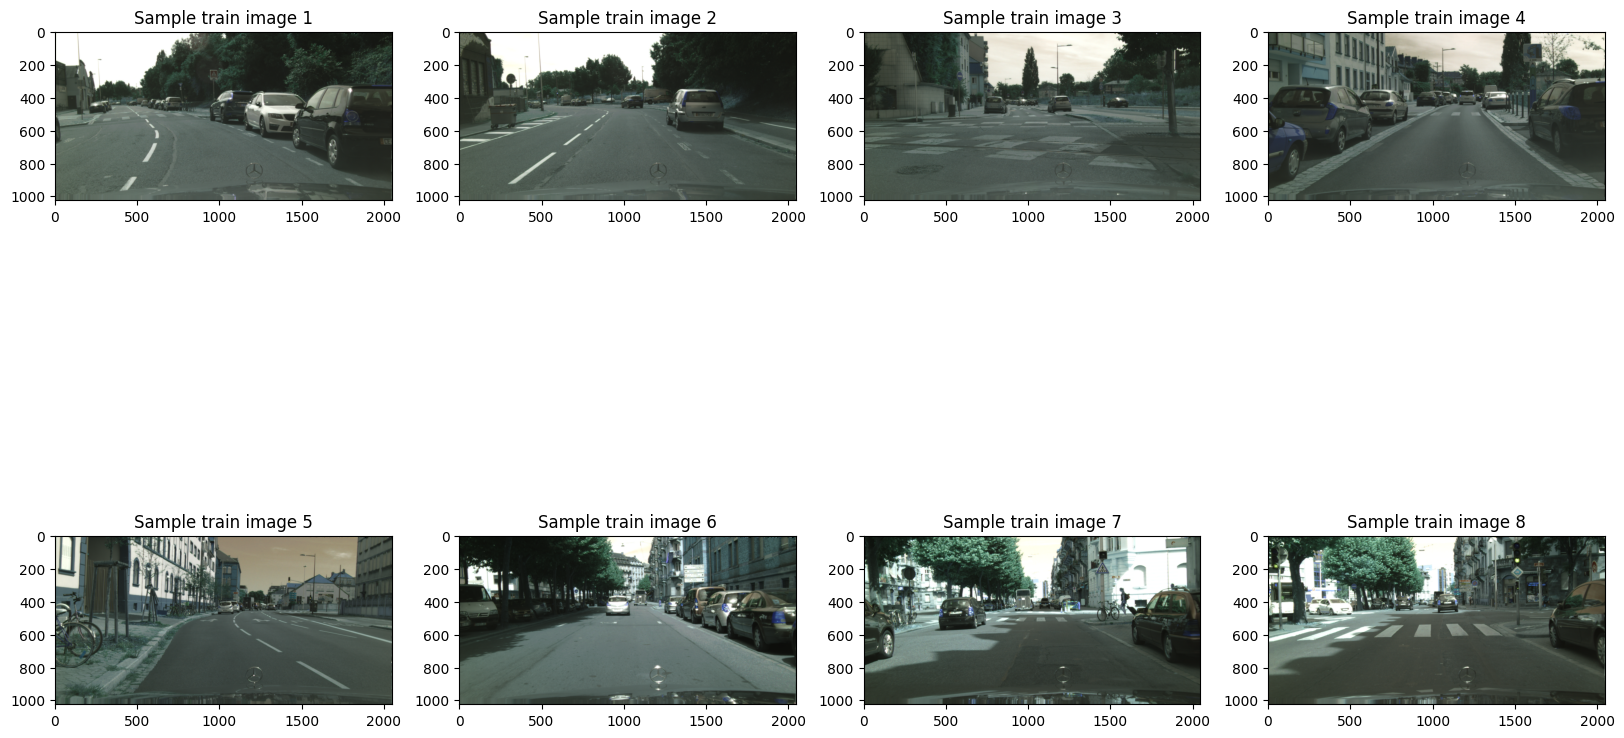

In [14]:
#Plot sample of train images
fig = plt.figure(figsize = (20,12))

for index in range(8):
  ax = fig.add_subplot(2,4,index+1)
  ax.set_title("Sample train image {}".format(index+1))
  ax.imshow(train_images[index], cmap='gray')

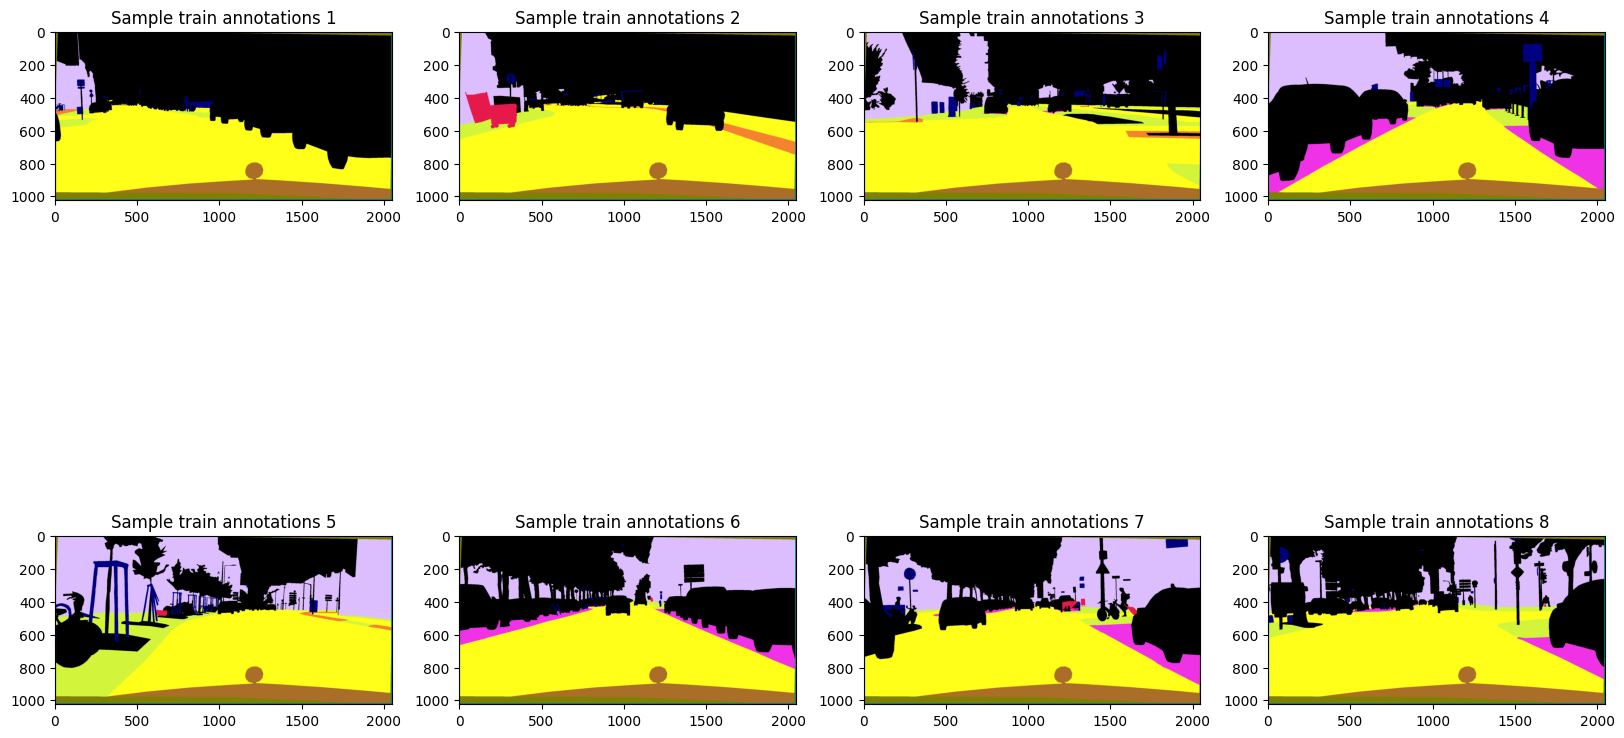

In [15]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))
mask_train = []

for index in range(8):
    #image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(2,4,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    masks = get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors)
    mask_train.append(masks)
    ax.imshow(masks)

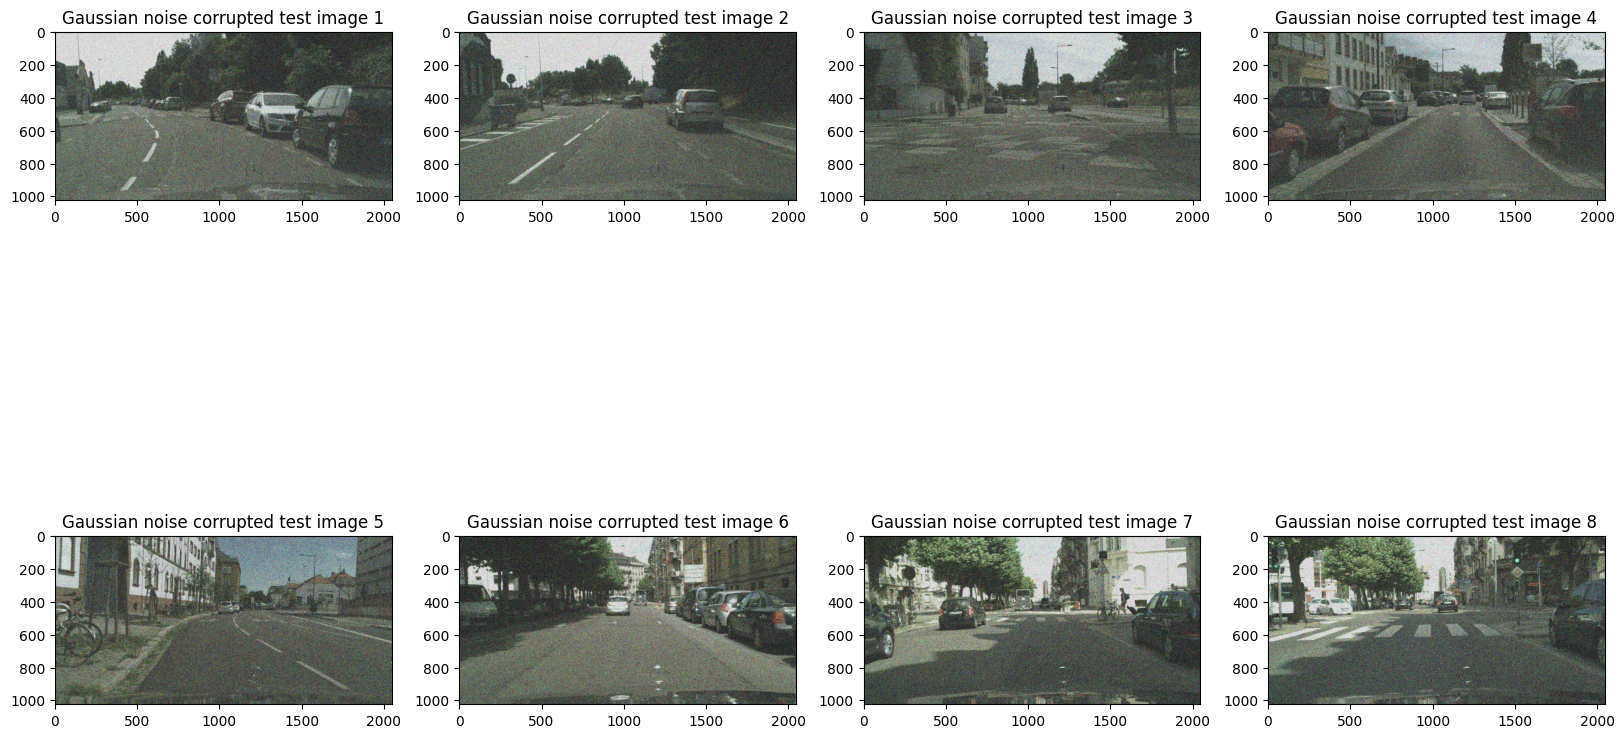

In [16]:
#Plot samples of gaussian noise corrupted test images
fig = plt.figure(figsize = (20,12))

for index in range(8):
  ax = fig.add_subplot(2,4,index+1)
  ax.set_title("Gaussian noise corrupted test image {}".format(index+1))
  ax.imshow(test_images_gaussian[index], cmap='gray')

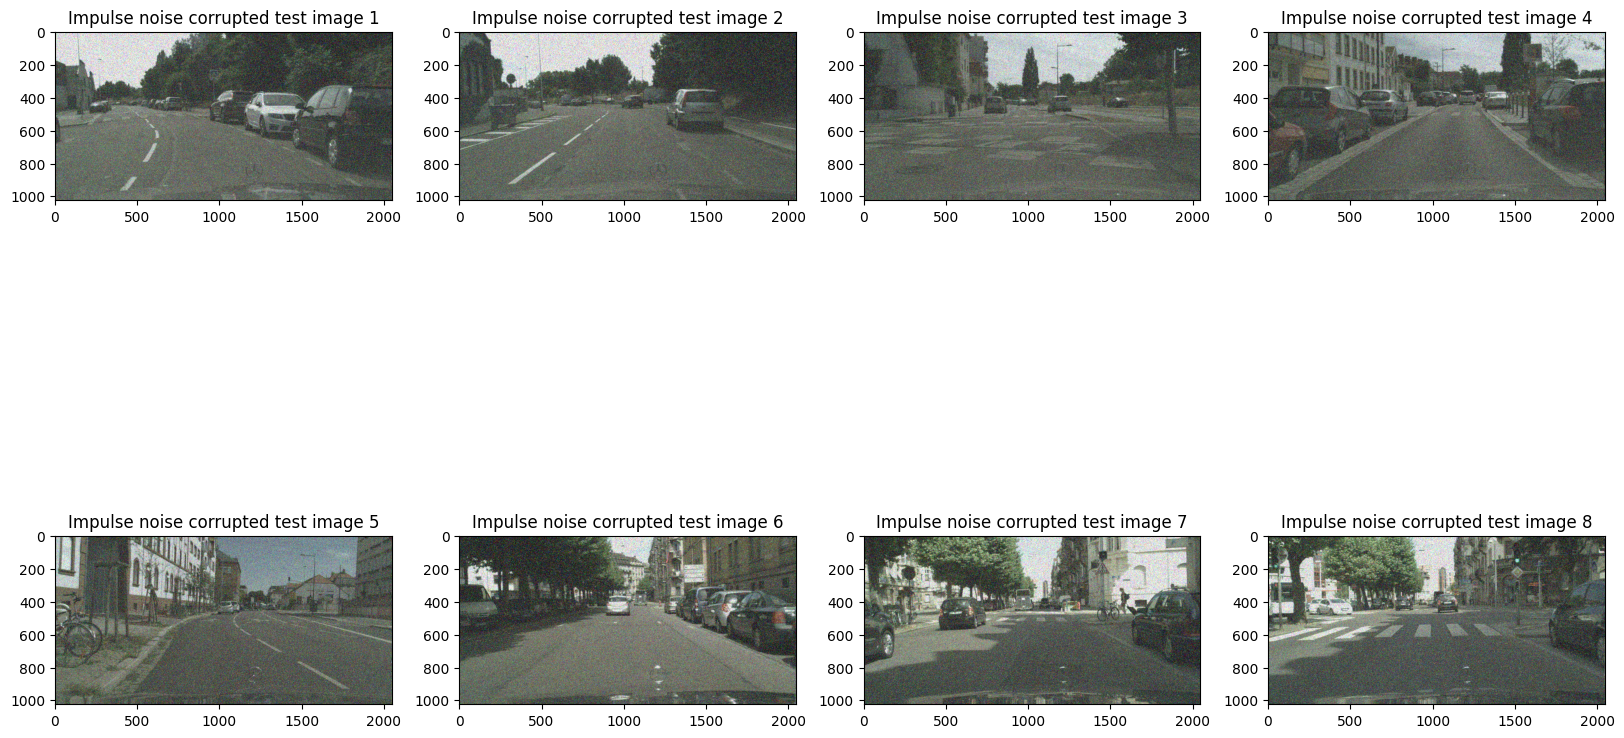

In [17]:
#Plot samples of impulse noise corrupted test images
fig = plt.figure(figsize = (20,12))

for index in range(8):
  ax = fig.add_subplot(2,4,index+1)
  ax.set_title("Impulse noise corrupted test image {}".format(index+1))
  ax.imshow(test_images_impulse[index], cmap='gray')

In [18]:
'''
#Plot samples of shot noise corrupted test images
fig = plt.figure(figsize = (20,12))

for index in range(8):
  ax = fig.add_subplot(2,4,index+1)
  ax.set_title("Sample of shot noise corrupted test images {}".format(index+1))
  ax.imshow(test_images_shot[index], cmap='gray')
'''

'\n#Plot samples of shot noise corrupted test images\nfig = plt.figure(figsize = (20,12))\n\nfor index in range(8):\n  ax = fig.add_subplot(2,4,index+1)\n  ax.set_title("Sample of shot noise corrupted test images {}".format(index+1))\n  ax.imshow(test_images_shot[index], cmap=\'gray\')\n'

In [19]:
#Resize images to 128 x 128 
train_images = []
for img in train_images_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  train_images.append(n)  

train_annotations = []
for img in train_annotations_dir:
  n = cv2.imread(img, cv2.IMREAD_UNCHANGED) #reading 1 dimension only
  n = cv2.resize(n, (128,128))
  train_annotations.append(n)

test_images_gaussian = []
for img in test_images_gaussian_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  test_images_gaussian.append(n)  

test_images_impulse = []
for img in test_images_impulse_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  test_images_impulse.append(n)  
'''
test_images_shot = []
for img in test_images_shot_dir:
  n = cv2.imread(img)
  n = cv2.resize(n, (128,128))
  test_images_shot.append(n)  
'''

'\ntest_images_shot = []\nfor img in test_images_shot_dir:\n  n = cv2.imread(img)\n  n = cv2.resize(n, (128,128))\n  test_images_shot.append(n)  \n'

In [20]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))

print("\nThere are {} gaussian noise corrupted test images".format(len(os.listdir(test_gaussian_path))))
print("\nThere are {} impulse noise corrupted test images".format(len(os.listdir(test_impulse_path))))
#print("\nThere are {} shot noise corrupted test images".format(len(os.listdir(test_images_shot))))

There are 365 images in train images

There are 365 images in train annotations

There are 365 gaussian noise corrupted test images

There are 365 impulse noise corrupted test images


In [21]:
print("shape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

print("\nshape of one sample image in gaussian noise corrupted dataset: {}".format(test_images_gaussian[0].shape))
print("\nshape of one sample image in impulse noise corrupted dataset: {}".format(test_images_impulse[0].shape))
#print("\nshape of one sample image in shot noise corrupted dataset: {}".format(test_images_shot[0].shape))

shape of one sample image in train images dataset: (128, 128, 3)

shape of one sample image in train annotations dataset: (128, 128)

shape of one sample image in gaussian noise corrupted dataset: (128, 128, 3)

shape of one sample image in impulse noise corrupted dataset: (128, 128, 3)


In [22]:
train_images = np.array(train_images)
train_annotations = np.array(train_annotations)

test_images_gaussian = np.array(test_images_gaussian)
test_images_impulse = np.array(test_images_impulse)
#test_images_shot = np.array(test_images_shot)

In [23]:
train_annotations = np.expand_dims(train_annotations, axis=-1)

In [24]:
x_train, x_test = train_images[:293], train_images[293:]
y_train, y_test = train_annotations[:293], train_annotations[293:]
test_images_gaussian = test_images_gaussian[293:]
test_images_impulse = test_images_impulse[293:]
#test_images_shot = test_images_shot[293:]

In [25]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

x_test_gaussian = np.array(test_images_gaussian)
x_test_impulse = np.array(test_images_impulse)
#x_test_shot = np.array(test_images_shot)

y_test = np.array(y_test)

In [26]:
y_train = np.array(y_train).squeeze()
y_test = np.array(y_test).squeeze()  #dimension removal

In [27]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))


x_train shape: (293, 128, 128, 3)
y_train shape: (293, 128, 128)
y_test shape: (72, 128, 128)


In [28]:
print("x_test_clean shape: {}".format(x_test.shape))
print("x_test_gaussian shape: {}".format(x_test_gaussian.shape))
print("x_test_impulse shape: {}".format(x_test_impulse.shape))
#print("x_test_shot shape: {}".format(x_test_shot.shape))

x_test_clean shape: (72, 128, 128, 3)
x_test_gaussian shape: (72, 128, 128, 3)
x_test_impulse shape: (72, 128, 128, 3)


In [29]:
classes = np.unique(y_train)
num_class = len(classes)
print("classes in image: {} : \n {}".format(num_class, classes))

classes in image: 34 : 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [30]:
label_train = tf.keras.utils.to_categorical(y_train, num_class)
label_test = tf.keras.utils.to_categorical(y_test, num_class)

#print(label_train)
#label_test

In [31]:
print("image shape: {}".format(x_train.shape))
print("label shape: {}".format(label_train.shape))
print("label test shape: {}".format(label_test.shape))     

image shape: (293, 128, 128, 3)
label shape: (293, 128, 128, 34)
label test shape: (72, 128, 128, 34)


In [32]:
y_train[0].shape

(128, 128)

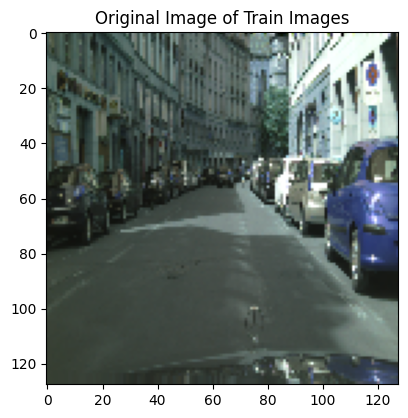

In [33]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Original Image of Train Images")
ax1.imshow(x_train[50], cmap='gray')

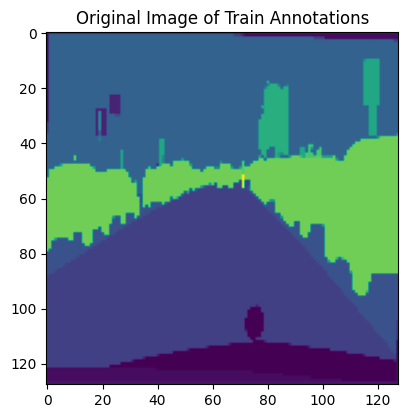

In [34]:
fig = plt.figure(figsize = (10,5))
ax2 = fig.add_subplot(1,2,1)
ax2.set_title("Original Image of Train Annotations")
ax2.imshow(y_train[50])     

# Model Training

In [35]:
height = x_train.shape[1]
width = x_train.shape[2]
channel = x_train.shape[3]     

In [36]:
'''
#UNet model architecture

inputs = tf.keras.Input((width, height, channel))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = Conv2D(34, 1, activation = 'softmax')(conv9)


model = tf.keras.Model(inputs, conv10)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
'''

"\n#UNet model architecture\n\ninputs = tf.keras.Input((width, height, channel))\n\nconv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)\nconv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n\nconv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)\nconv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n\nconv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)\nconv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)\npool3 = MaxPooling2D(pool_size=(2, 2))(conv3)\n\nconv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)\nconv4 = Conv2D(512, 3, activation = 'relu'

In [37]:
'''
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
      print("\nReached 85% validation accuracy so cancelling training!")
      self.model.stop_training = True
'''    

'\nclass myCallback(tf.keras.callbacks.Callback):\n  def on_epoch_end(self, epoch, logs={}):\n    if logs.get(\'accuracy\') is not None and logs.get(\'val_accuracy\') > 0.85:\n      print("\nReached 85% validation accuracy so cancelling training!")\n      self.model.stop_training = True\n'

In [38]:
'''
callbacks = myCallback()

history = model.fit(
    x_train,
    label_train,
    validation_data=(x_test, label_test),
    epochs=50,
    batch_size=4,
    callbacks=[callbacks]
)
'''    

'\ncallbacks = myCallback()\n\nhistory = model.fit(\n    x_train,\n    label_train,\n    validation_data=(x_test, label_test),\n    epochs=50,\n    batch_size=4,\n    callbacks=[callbacks]\n)\n'

In [39]:
'''
#model training plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(epochs, acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend(loc=0)

ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend(loc=0)
'''  

"\n#model training plots\n\nacc = history.history['accuracy']\nval_acc = history.history['val_accuracy']\n\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepochs = range(len(acc))\n\nfig = plt.figure(figsize = (15,5))\nax1 = fig.add_subplot(1,2,1)\nax2 = fig.add_subplot(1,2,2)\n\nax1.plot(epochs, acc, label='Training Accuracy')\nax1.plot(epochs, val_acc, label='Validation Accuracy')\nax1.set_title('Training and Validation Accuracy')\nax1.legend(loc=0)\n\nax2.plot(epochs, loss, label='Training Loss')\nax2.plot(epochs, val_loss, label='Validation Loss')\nax2.set_title('Training and Validation Loss')\nax2.legend(loc=0)\n"

In [40]:
#save model
#model.save('/content/gdrive/MyDrive/UNet.h5')

In [41]:
#load saved model
unet = tf.keras.models.load_model('/content/gdrive/MyDrive/unet.h5')
unet_fault = tf.keras.models.load_model('/content/gdrive/MyDrive/model_segment.h5')

# Helper functions

In [42]:
#Calculate mean IoU

def evaluate_mIoU(x, model):
  y_pred = model.predict(x)
  y_pred_argmax = np.argmax(y_pred, axis=3)
  y_pred_argmax.shape
  #metrics = model.evaluate(x_test, y_pred)
  #print("{}: {}".format(model.metrics_names[0], metrics[0]))
  #print("{}: {}".format(model.metrics_names[1], metrics[1]))

  IOU_keras = MeanIoU(num_classes=num_class)
  IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
  IoU = IOU_keras.result().numpy()
  print("Mean IoU =", IoU)
  values = np.array(IOU_keras.get_weights()).reshape(num_class, num_class)
  if model == unet:
    model_mIoU['UNet'].append(IoU*100)
  else:
    model_mIoU['UNet_fault'].append(IoU*100)

  return IoU, y_pred_argmax, values

In [43]:
#Calculate IoU of each class

def IoU_per_class(values):
  val = 0
  total = 0
  res = []

  for i in range (num_class):
    val = values[i,i]
    sum1 = 0

    for j in range (num_class):
      sum1 = values[i,j] + sum1
    sum2 = 0

    for x in range(num_class):
      if x != i:
        sum2 = values[x, i] + sum2
      else:
        continue
    total = sum1 + sum2
    res.append(val/total)
    print("IoU class {}: {}".format(i,res[i]))
  plot_IoU_per_class(res)
  return

In [79]:
# Plot IoU values of each class in a histogram

def plot_IoU_per_class(res):
  index = []
  for i in range (len(res)):
    index.append(i)
  plt.figure(figsize=(12,6))
  plt.title("IoU for each class", fontsize=14)
  plt.xlabel("Classes", fontsize=12)
  plt.ylabel("mean IoU values", fontsize=12)
  plt.bar(index, res)

In [80]:
#Plot inference

def plot_inference(test_images, test_labels, pred_labels):
  num = random.randint(0,len(test_images))

  plt.figure(figsize=(20,20))

  plt.subplot(231)
  plt.title('Original Test Image', fontsize=20, pad=20)
  plt.imshow(test_images[num])

  plt.subplot(232)
  plt.title('Test Image Label', fontsize=20, pad=20)
  plt.imshow(test_labels[num].squeeze(), cmap='jet')

  plt.subplot(233)
  plt.title('Predicted Image Label', fontsize=20, pad=20)
  plt.imshow(pred_labels[num], cmap='jet')

  plt.show()

In [81]:
#Calculate RLA i.e. here Relative Loss of mean IoU

def RLA(IoU_clean, IoU_corr, model):
  RLA = (IoU_clean - IoU_corr) / IoU_clean
  if model == unet:
    model_RLA['UNet'].append(RLA*100)
  else:
    model_RLA['UNet_fault'].append(RLA*100)
  return RLA



In [82]:
#Calculate ELA i.e. here Equalized Loss of mean IoU

def ELA(IoU_clean, IoU_corr, model):
  ELA = (100 - IoU_corr) / IoU_clean
  if model == unet:
    model_ELA['UNet'].append(ELA)
  else:
    model_ELA['UNet_fault'].append(ELA)
  return ELA


In [122]:
#List of image corrutpions for visualizations

image_corruptions = ["Gaussian Noise", "Impulse Noise"]


#Initialising dictionaries to store lists of mean IoU and RL-mIoU, EL-mIoU scores for all models/corruptions
model_mIoU = {
      'UNet': [] ,'UNet_fault': []
        }

model_RLA = {
      'UNet': [],'UNet_fault': []
            }

model_ELA = {
      'UNet': [],'UNet_fault': []
              }



# Clean test data evaluation on U-Net model

In [123]:
mIoU1, y_pred_argmax, values = evaluate_mIoU(x_test, unet)

3/3 [==============================] - 0s 183ms/step
Mean IoU = 0.26824552


IoU class 0: 0.0
IoU class 1: 0.999507219974017
IoU class 2: 0.9959732938456343
IoU class 3: 0.9994081885188573
IoU class 4: 0.055105348460291734
IoU class 5: 0.10616587060356057
IoU class 6: 0.025903561739739213
IoU class 7: 0.9208049235169438
IoU class 8: 0.6565038580549136
IoU class 9: 0.0005111167901865576
IoU class 10: 0.0822566752799311
IoU class 11: 0.8040074874500127
IoU class 12: 0.04117782378651944
IoU class 13: 0.34348695881931074
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.1180629955003214
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.05753184014053579
IoU class 21: 0.8134970588002438
IoU class 22: 0.26053484602917343
IoU class 23: 0.9270340406044879
IoU class 24: 0.24032492201253977
IoU class 25: 0.0
IoU class 26: 0.6556309843457115
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.01691948658109685


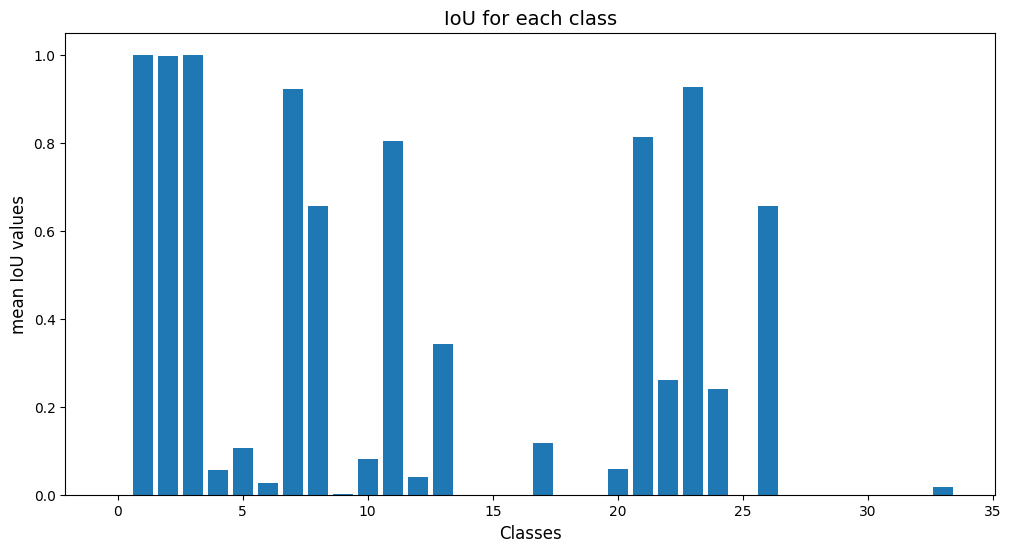

In [124]:
IoU_per_class(values)

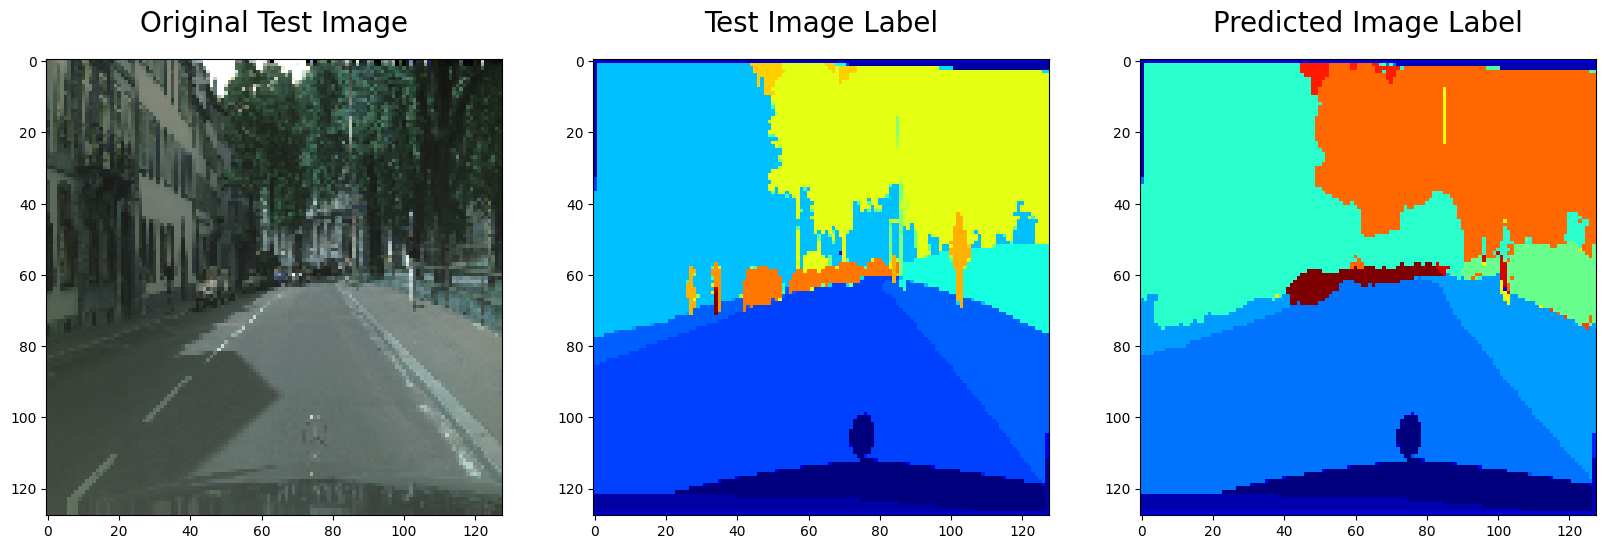

In [125]:
plot_inference(x_test, y_test, y_pred_argmax)

# Clean test data evaluation on U-Net faulty model

In [126]:
mIoU1_fault, y_pred_argmax1_fault, values1_fault = evaluate_mIoU(x_test, unet_fault)

3/3 [==============================] - 0s 173ms/step
Mean IoU = 0.20993248


IoU class 0: 0.0
IoU class 1: 0.9954007884362681
IoU class 2: 0.9940711974110032
IoU class 3: 0.9974203256838824
IoU class 4: 0.041606689971896635
IoU class 5: 0.09893686266001302
IoU class 6: 0.03379598575924875
IoU class 7: 0.8256525354900521
IoU class 8: 0.37864511465930745
IoU class 9: 0.0002545824847250509
IoU class 10: 0.00021684918139434025
IoU class 11: 0.6988941505677232
IoU class 12: 0.01698026617714548
IoU class 13: 0.04625337476440324
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.033445566778900114
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.0001501726986033939
IoU class 21: 0.7061475502840415
IoU class 22: 0.0
IoU class 23: 0.8224882617566803
IoU class 24: 0.03263455581990394
IoU class 25: 0.0
IoU class 26: 0.41292427153378164
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.0017857142857142857


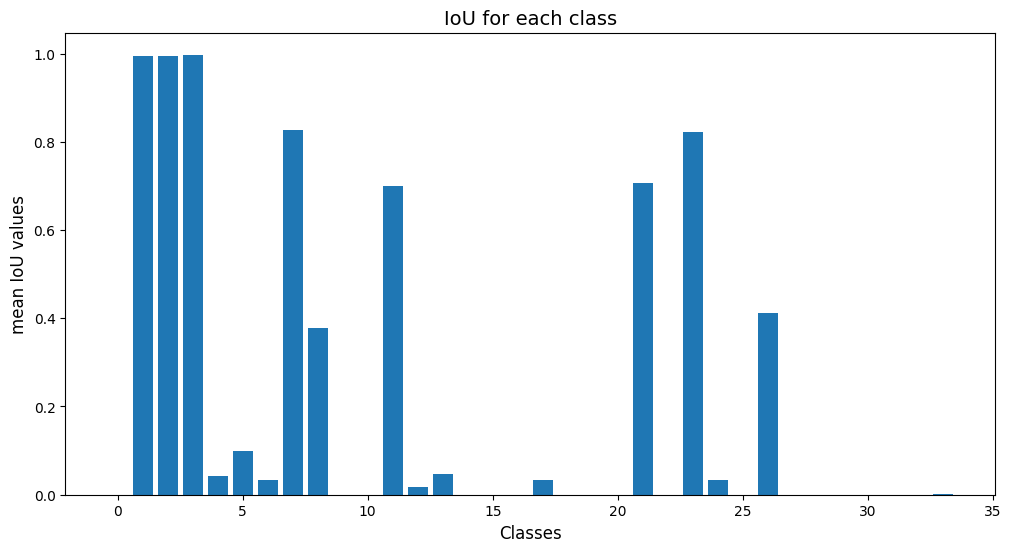

In [127]:
IoU_per_class(values1_fault)

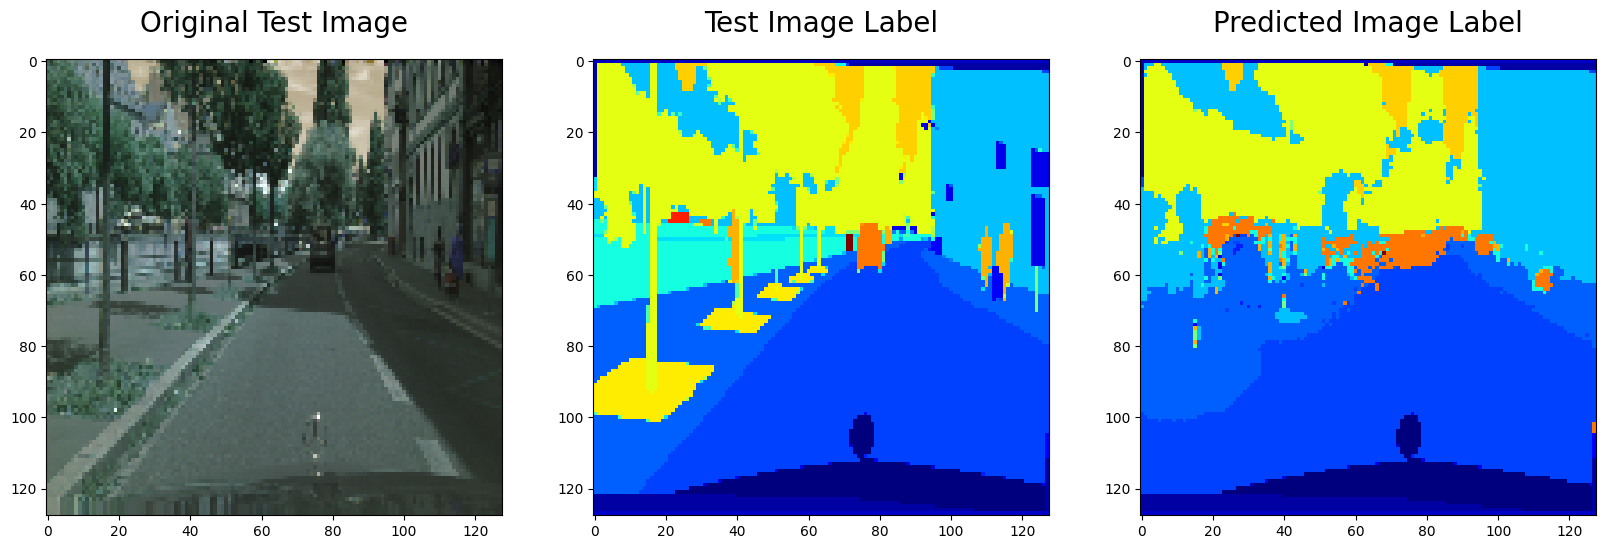

In [128]:
plot_inference(x_test, y_test, y_pred_argmax1_fault)

#Gaussian Noise Corrupted test data evaluation on U-Net model

In [129]:
mIoU2, y_pred_argmax2, values2 = evaluate_mIoU(x_test_gaussian, unet)

3/3 [==============================] - 0s 184ms/step
Mean IoU = 0.11607057


IoU class 0: 0.0
IoU class 1: 0.8580047181364651
IoU class 2: 0.9722970871773609
IoU class 3: 0.906911901384337
IoU class 4: 0.03237350657930958
IoU class 5: 0.03641691084135622
IoU class 6: 0.021359830999139347
IoU class 7: 0.438231881796607
IoU class 8: 0.013257312381217263
IoU class 9: 0.0014231499051233396
IoU class 10: 0.00021630975556997622
IoU class 11: 0.2713422642500657
IoU class 12: 0.008046490835940992
IoU class 13: 0.046993262912750564
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.0008159026850615635
IoU class 18: 0.0
IoU class 19: 0.000419639110365086
IoU class 20: 0.016496115541257402
IoU class 21: 0.14772584011542395
IoU class 22: 0.001985440105890139
IoU class 23: 0.021998536794571002
IoU class 24: 0.07834265846975663
IoU class 25: 0.0035514967021816335
IoU class 26: 0.05847570388549053
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.009713500784929356


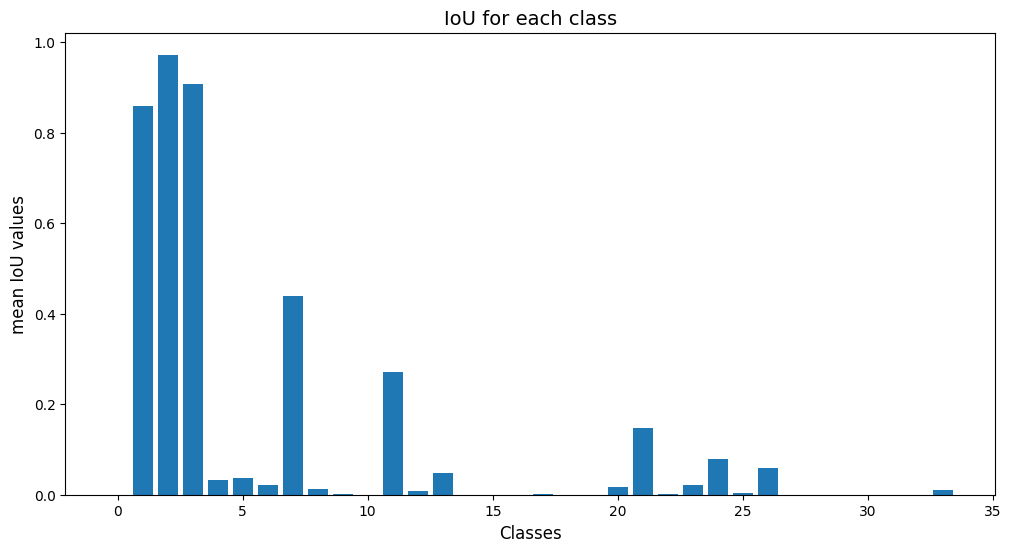

In [130]:
IoU_per_class(values2)

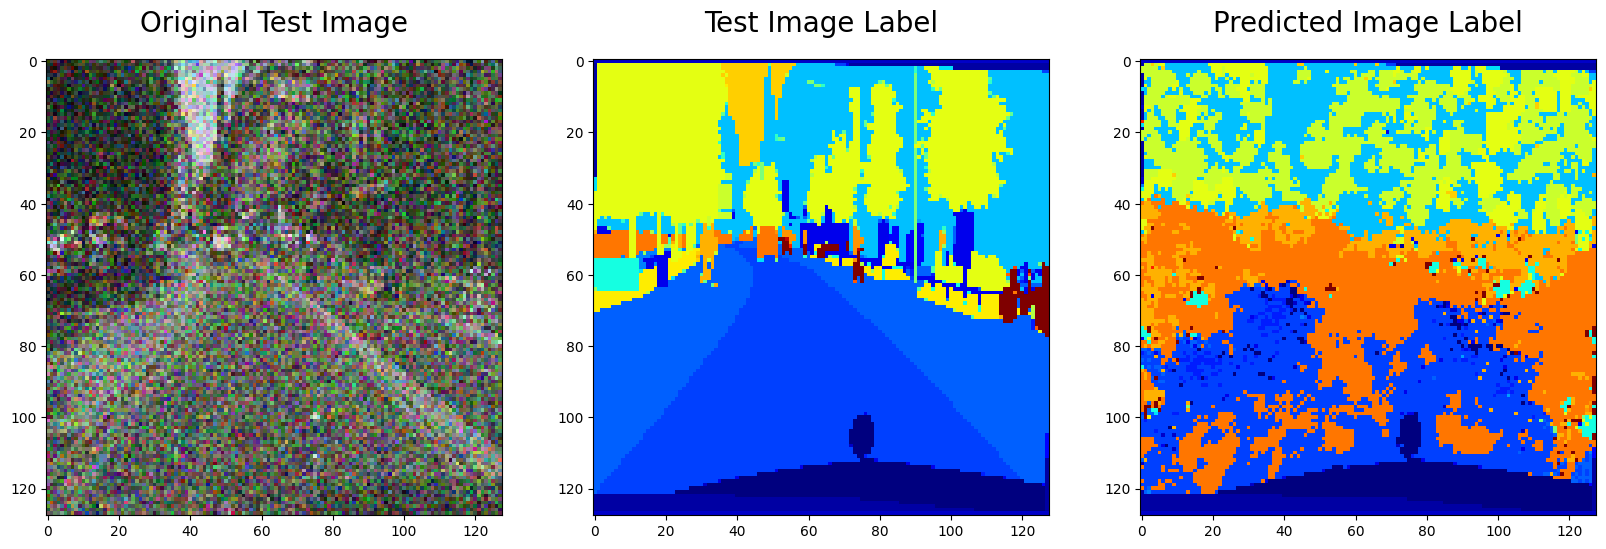

In [131]:
plot_inference(x_test_gaussian, y_test, y_pred_argmax2)

In [132]:
RLA(mIoU1, mIoU2, unet)

0.5672973

In [133]:
ELA(mIoU1, mIoU2, unet)

372.36010539477155

#Gaussian Noise Corrupted test data evaluation on faulty U-Net model

In [134]:
mIoU2_fault, y_pred_argmax2_fault, values2_fault = evaluate_mIoU(x_test_gaussian, unet_fault)

3/3 [==============================] - 0s 183ms/step
Mean IoU = 0.12234657


IoU class 0: 0.0
IoU class 1: 0.9698609753606909
IoU class 2: 0.9755705314749579
IoU class 3: 0.9871043376318874
IoU class 4: 0.016746133271310616
IoU class 5: 0.01779284049989409
IoU class 6: 0.0039149888143176735
IoU class 7: 0.32055874114438543
IoU class 8: 0.03292698253110469
IoU class 9: 0.0003627130939426913
IoU class 10: 0.0003137418950010458
IoU class 11: 0.4551512980785895
IoU class 12: 0.00478885502829778
IoU class 13: 0.017084282460136675
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.0003708098487095817
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.00029846291598268916
IoU class 21: 0.25489789510477084
IoU class 22: 0.00022036139268400177
IoU class 23: 0.03968127720495727
IoU class 24: 0.01605368968779565
IoU class 25: 0.0
IoU class 26: 0.044901357764676464
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.001183151916706105


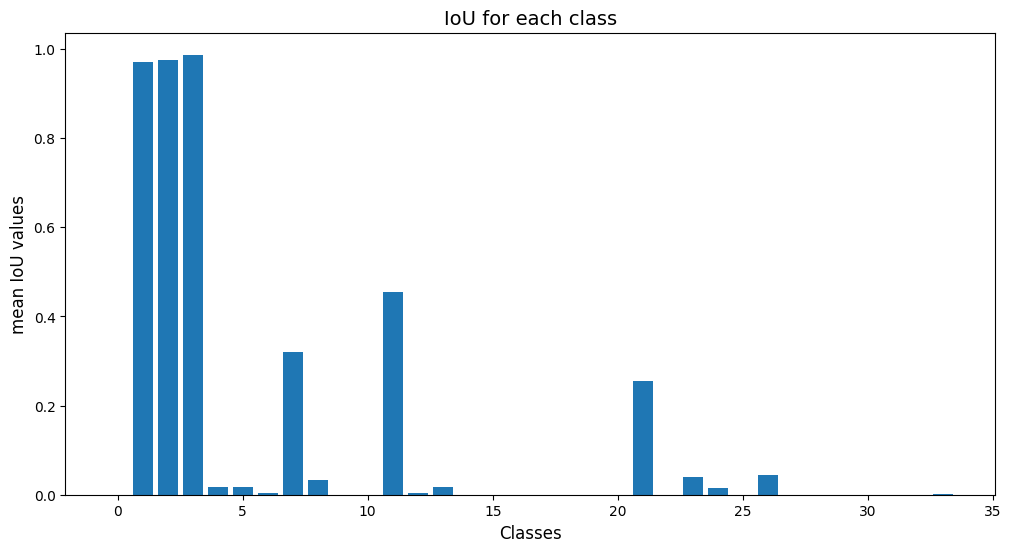

In [135]:
IoU_per_class(values2_fault)

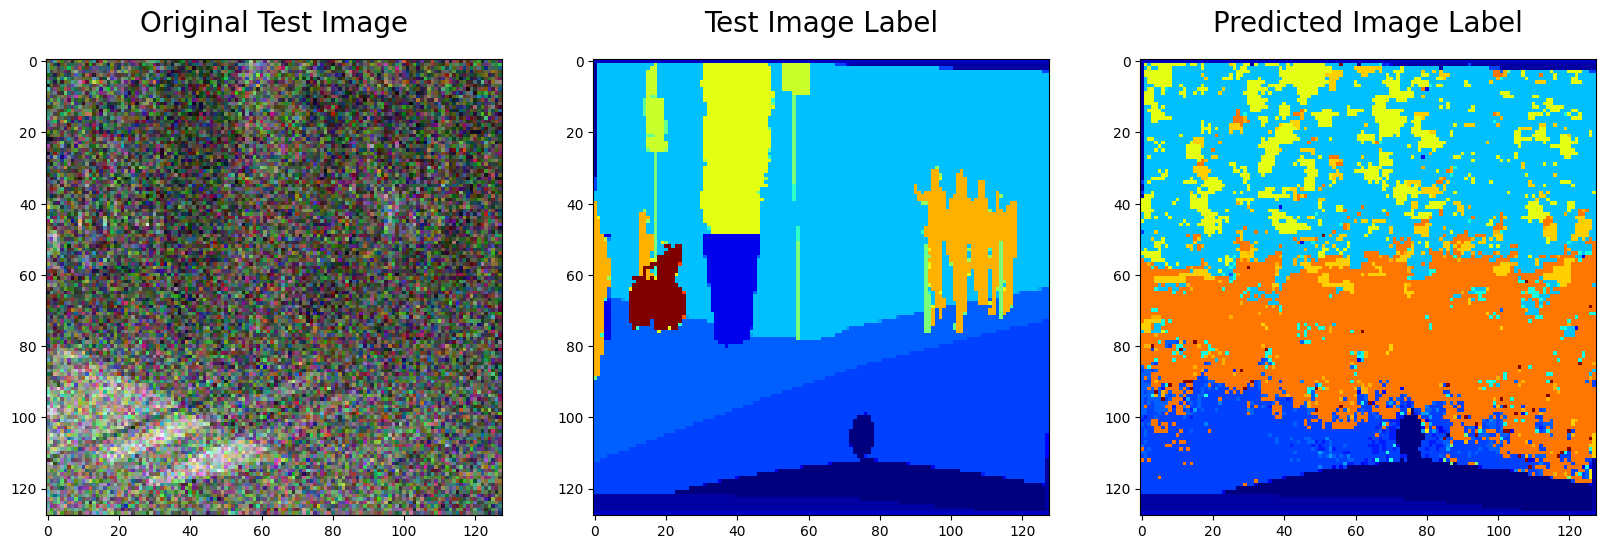

In [136]:
plot_inference(x_test_gaussian, y_test, y_pred_argmax2_fault)

In [137]:
RLA(mIoU1, mIoU2_fault, unet_fault)

0.5439007

In [138]:
ELA(mIoU1, mIoU2_fault, unet_fault)

372.3367089031607

#Impulse Noise Corrupted test data evaluation on U-Net model

In [139]:
mIoU3, y_pred_argmax3, values3 = evaluate_mIoU(x_test_impulse, unet)

3/3 [==============================] - 0s 188ms/step
Mean IoU = 0.11859152


IoU class 0: 0.0
IoU class 1: 0.8199288869203607
IoU class 2: 0.9729883717918836
IoU class 3: 0.9262589928057554
IoU class 4: 0.032616507269611364
IoU class 5: 0.049677821658698815
IoU class 6: 0.024880776654933576
IoU class 7: 0.4937857755096009
IoU class 8: 0.016803853536099218
IoU class 9: 0.0007105637138796779
IoU class 10: 0.00032078699743370403
IoU class 11: 0.2973232353081896
IoU class 12: 0.010666666666666666
IoU class 13: 0.032442112277194735
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.001115324559446799
IoU class 18: 0.0
IoU class 19: 0.0012295081967213116
IoU class 20: 0.015596276564603946
IoU class 21: 0.16058284833960973
IoU class 22: 0.0
IoU class 23: 0.01801505887109
IoU class 24: 0.07220237409242826
IoU class 25: 0.002523977788995457
IoU class 26: 0.07041347875630799
IoU class 27: 0.0
IoU class 28: 0.000691085003455425
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.011337413464432627


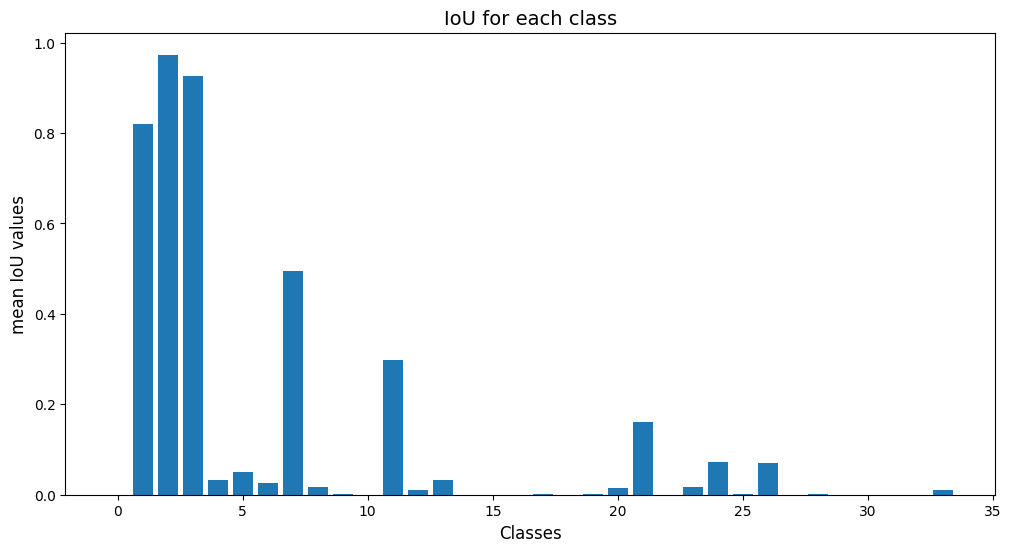

In [140]:
IoU_per_class(values3)

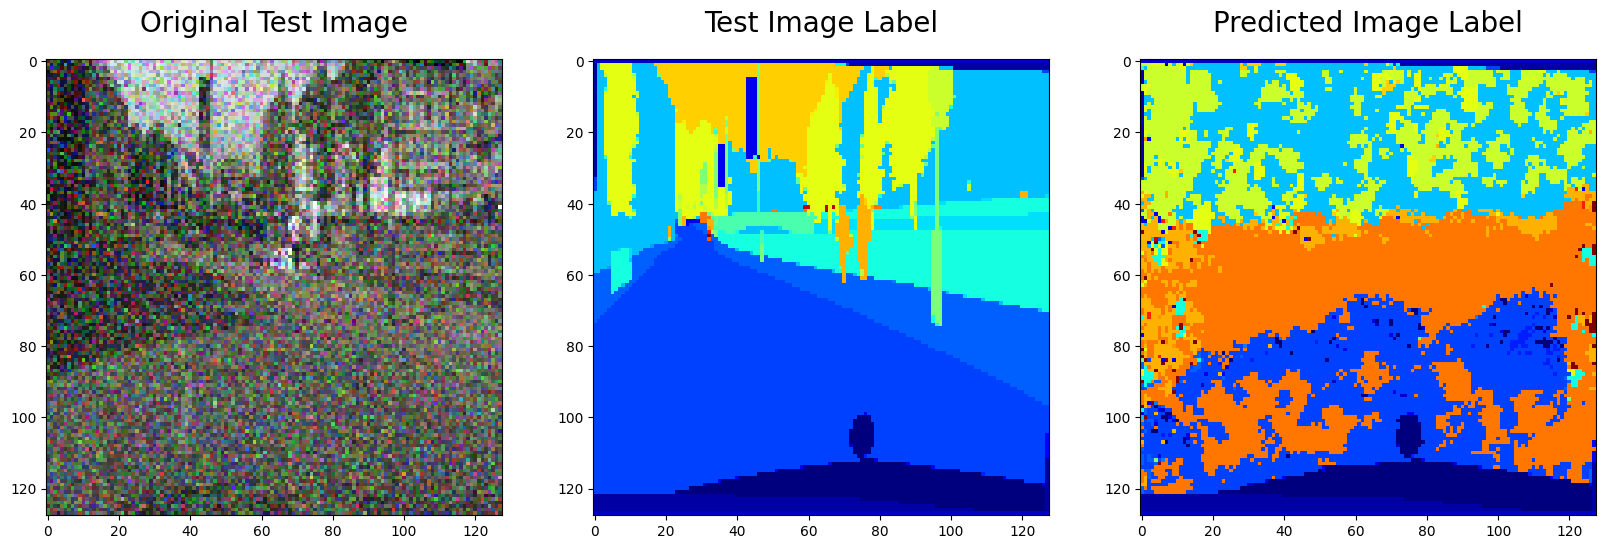

In [141]:
plot_inference(x_test_impulse, y_test, y_pred_argmax3)

In [142]:
RLA(mIoU1, mIoU3, unet)

0.55789936

In [143]:
ELA(mIoU1, mIoU3, unet)

372.3507074795136

#Impulse Noise Corrupted test data evaluation on faulty U-Net model

In [144]:
mIoU3_fault, y_pred_argmax3_fault, values3_fault = evaluate_mIoU(x_test_impulse, unet_fault)

3/3 [==============================] - 0s 141ms/step
Mean IoU = 0.12857336


IoU class 0: 0.0
IoU class 1: 0.972808785303309
IoU class 2: 0.9763697144461173
IoU class 3: 0.9885714285714285
IoU class 4: 0.019096079018258008
IoU class 5: 0.034013605442176874
IoU class 6: 0.006327985739750445
IoU class 7: 0.4378910178714186
IoU class 8: 0.05890856234675867
IoU class 9: 0.0017608733932030288
IoU class 10: 0.00031204493447056374
IoU class 11: 0.4643061253885577
IoU class 12: 0.005633802816901409
IoU class 13: 0.016088505531595725
IoU class 14: 0.0
IoU class 15: 0.0
IoU class 16: 0.0
IoU class 17: 0.0007496251874062968
IoU class 18: 0.0
IoU class 19: 0.0
IoU class 20: 0.00044822949350067237
IoU class 21: 0.2887711299920069
IoU class 22: 0.0
IoU class 23: 0.03471741637831603
IoU class 24: 0.01641488864662825
IoU class 25: 0.0
IoU class 26: 0.04740251049671482
IoU class 27: 0.0
IoU class 28: 0.0
IoU class 29: 0.0
IoU class 30: 0.0
IoU class 31: 0.0
IoU class 32: 0.0
IoU class 33: 0.000902178115736564


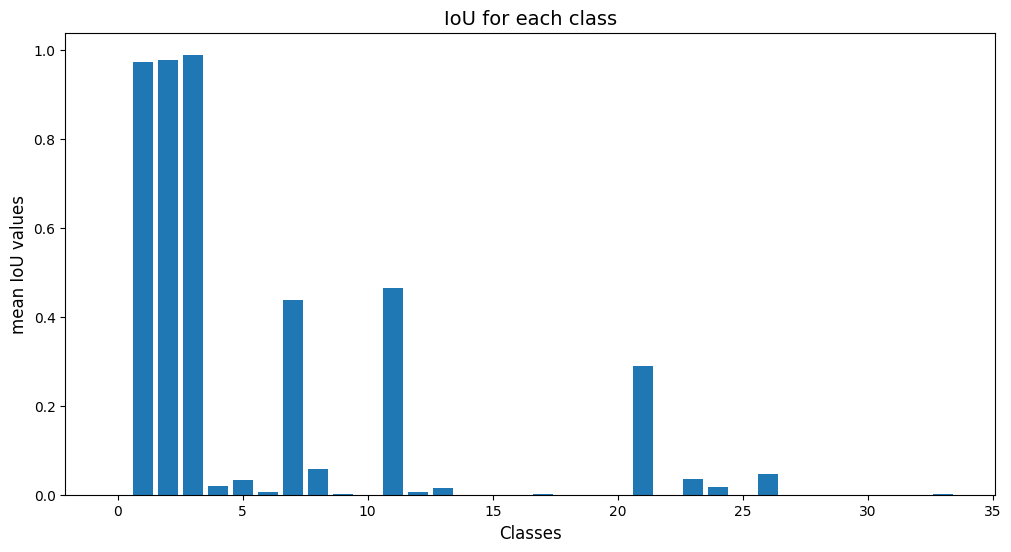

In [145]:
IoU_per_class(values3_fault)

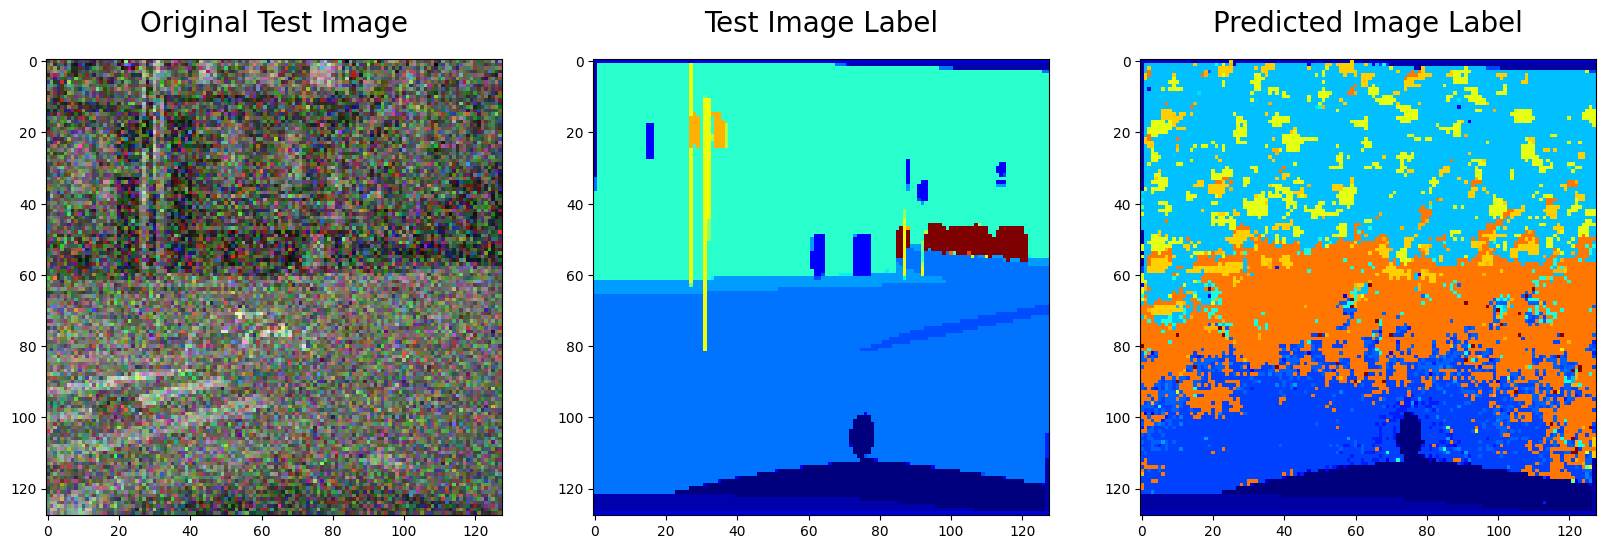

In [146]:
plot_inference(x_test_impulse, y_test, y_pred_argmax3_fault)

In [147]:
RLA(mIoU1, mIoU3_fault, unet_fault)

0.52068776

In [148]:
ELA(mIoU1, mIoU3_fault, unet_fault)

372.3134958947101

In [149]:
print(model_RLA)

{'UNet': [56.72972798347473, 55.78993558883667], 'UNet_fault': [54.3900728225708, 52.06877589225769]}


In [150]:
print(model_ELA)

{'UNet': [372.36010539477155, 372.3507074795136], 'UNet_fault': [372.3367089031607, 372.3134958947101]}


In [151]:
print(model_mIoU)

{'UNet': [26.824551820755005, 11.607056856155396, 11.859151721000671], 'UNet_fault': [20.993247628211975, 12.234657257795334, 12.857335805892944]}


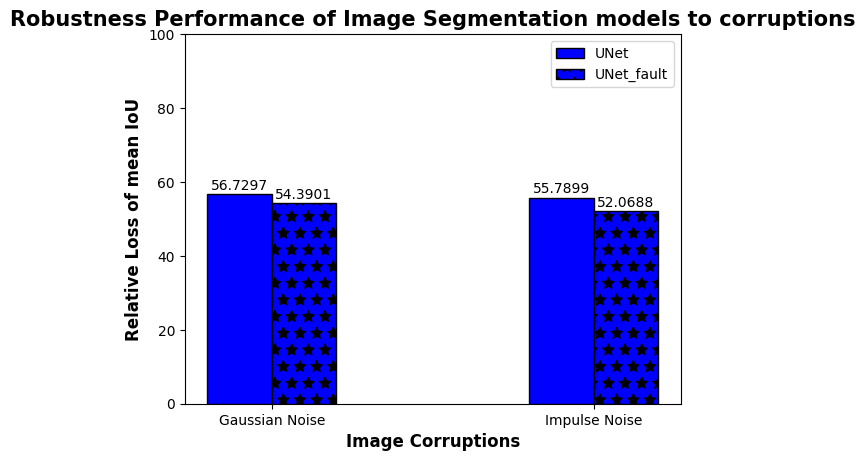

<Figure size 2000x700 with 0 Axes>

In [163]:
#RLA VISUALIZATIONS


dummy_variable = 1                                # for selecting different plots
mark = 1                                          # for selecting all/one corruption

if ((dummy_variable == 0) and (mark ==0)):        # plot all models (clean and faulty) robustness performance vs mean IoU to corruptions in a SCATTER PLOT
  i = 0                                           # select corruption type, 0 = gaussian noise, 1 = impulse noise
  j = image_corruptions[i]                        # save corruption type in var j 

  #plot scatter plots
  d1 = plt.scatter(model_mIoU['UNet'][i], model_RLA['UNet'][i], s = 150, color='blue')
  d2 = plt.scatter(model_mIoU['UNet_fault'][i], model_RLA['UNet_fault'][i], s=150, marker="X", color='blue')

  # get the x and y coordinates of the points in d1 and d2
  x1, y1 = d1.get_offsets().T
  x2, y2 = d2.get_offsets().T
  #connect the corresponding points with a line

  for i in range(len(x1)):
      plt.plot([x1[i], x2[i]], [y1[i], y2[i]], 'k--')
      plt.grid()

  #plot information
  plt.xlim(0,60)
  plt.ylim(30,60)
  plt.ylabel('Relative Loss of mean IoU',fontweight="bold", fontsize="12")
  plt.xlabel('mean IoU',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Segmentation models to ' + j + ' Corruption' ,fontweight="bold", fontsize="15")
  plt.legend(loc='upper left')
  plt.legend(["UNet", "UNet_fault"])
  plt.figure(figsize=(10,6))
  plt.show()

  
elif ((dummy_variable == 1) and (mark == 1)):      #plot all models robustness performance for all corruptions in a GROUPED HISTOGRAM
  x = np.arange(len(image_corruptions))
  width = 0.2

  # plot data in grouped manner of bar type
  x1 = plt.bar(x+0.4, model_RLA['UNet'], width, color='blue', edgecolor='black',linewidth=1)
  plt.bar_label(x1, padding =1, fontsize=10)
  x2 = plt.bar(x+0.6, model_RLA['UNet_fault'], width, color='blue', hatch="*",edgecolor='black', linewidth=1)
  plt.bar_label(x2, padding =1, fontsize=10)
  
  plt.ylabel('Relative Loss of mean IoU',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xticks(x+0.5, image_corruptions)
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Segmentation models to corruptions',fontweight="bold", fontsize="15")
  plt.legend(loc='upper left')
  plt.legend(["UNet", "UNet_fault"])
  plt.figure(figsize=(20,7))
  plt.show()

elif ((dummy_variable == 1) and (mark == 0)): #plot clean models robustness performance for corruptions
  x = np.arange(len(image_corruptions))
  width = 0.2

  # plot data in grouped manner of bar type
  X1 = plt.bar(x+0.2, model_RLA['UNet'], width, color='purple')
  plt.bar_label(X1, padding =1)

  X2 = plt.bar(x+0.4, model_RLA['UNet_fault'], width, color='orange') #CHECK
  plt.bar_label(X2, padding =1)


  plt.ylabel('Relative Loss of mean IoU',fontweight="bold", fontsize="12")
  plt.ylim(0, 100)
  plt.xticks(x+0.3, image_corruptions)
  plt.xlabel('Image Corruptions',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Segmentation models to common corruptions',fontweight="bold", fontsize="15")
  plt.legend(loc='upper left')
  plt.legend(["UNet", "UNet_fault"])
  plt.figure(figsize=(25,10))
  plt.show()

elif ((dummy_variable == 0) and (mark ==1)):
  i = 0                                           # select corruption type; 0 = gaussian noise, 1 = impulse noise
  j = image_corruptions[i]                        # save corruption type in var j 

  #plot scatter plots
  d1 = plt.scatter(model_mIoU['UNet'][i], model_RLA['UNet'][i], s = 150, color='red')
  plt.grid()

  d2 = plt.scatter(model_mIoU['UNet_fault'][i], model_RLA['UNet_fault'][i], s = 150, color='red', marker = 'X')

  #plot information
  plt.xlim(10,70)
  plt.ylim(10,70)
  plt.ylabel('Relative Loss of mean IoU',fontweight="bold", fontsize="12")
  plt.xlabel('mean IoU',fontweight="bold", fontsize="12")
  plt.title('Robustness Performance of Image Segmentation models to '+ j + ' Corruption' ,fontweight="bold", fontsize="15")
  plt.legend(loc='upper left')
  plt.legend(["UNet", "UNet fault"])
  plt.figure(figsize=(10,6))
  plt.show()
